In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [15]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


In [16]:
anchor = tf.data.Dataset.list_files(f'{ANC_PATH}/*.jpg').take(50)
positive = tf.data.Dataset.list_files(f'{POS_PATH}/*.jpg').take(50)
negative = tf.data.Dataset.list_files(f'{NEG_PATH}/*.jpg').take(50)
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/421fd302-4f07-11ef-8e5a-b48c9d5129fd.jpg'


In [17]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img


In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data/anchor/48fdee1e-4f07-11ef-80b6-b48c9d5129fd.jpg',
 b'data/positive/4401680b-4f07-11ef-853d-b48c9d5129fd.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [21]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()

In [22]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
l1 = L1Dist()

In [23]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()

TypeError: Exception encountered when calling L1Dist.call().

[1mCould not automatically infer the output shape / dtype of 'l1_dist_8' (of type L1Dist). Either the `L1Dist.call()` method is incorrect, or you need to implement the `L1Dist.compute_output_spec() / compute_output_shape()` method. Error encountered:

unsupported operand type(s) for -: 'list' and 'list'[0m

Arguments received by L1Dist.call():
  • args=(['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_57>'], ['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_58>'])
  • kwargs=<class 'inspect._empty'>

In [5]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [16]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y


array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [6]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [7]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [19]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 11s 463ms/step

 Epoch 2/50
5/5 [==============================] - 1s 184ms/step

 Epoch 3/50
5/5 [==============================] - 1s 183ms/step

 Epoch 4/50
5/5 [==============================] - 1s 177ms/step

 Epoch 5/50
5/5 [==============================] - 1s 177ms/step

 Epoch 6/50
5/5 [==============================] - 1s 176ms/step

 Epoch 7/50
5/5 [==============================] - 1s 175ms/step

 Epoch 8/50
5/5 [==============================] - 1s 175ms/step

 Epoch 9/50
5/5 [==============================] - 1s 180ms/step

 Epoch 10/50
5/5 [==============================] - 1s 182ms/step

 Epoch 11/50
5/5 [==============================] - 1s 214ms/step

 Epoch 12/50
5/5 [==============================] - 1s 184ms/step

 Epoch 13/50
5/5 [==============================]

In [20]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 145ms/step


array([[9.9998724e-01],
       [4.4448875e-06],
       [9.9995852e-01],
       [9.9976248e-01],
       [1.0000000e+00],
       [9.9864632e-01],
       [1.7124773e-07],
       [5.3444030e-08],
       [1.0000000e+00],
       [9.9974400e-01],
       [2.4649753e-06],
       [1.0000000e+00],
       [1.0873239e-07],
       [9.9981648e-01],
       [9.9971992e-01],
       [1.0000000e+00]], dtype=float32)

In [8]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


NameError: name 'y_hat' is not defined

In [22]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [23]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [24]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

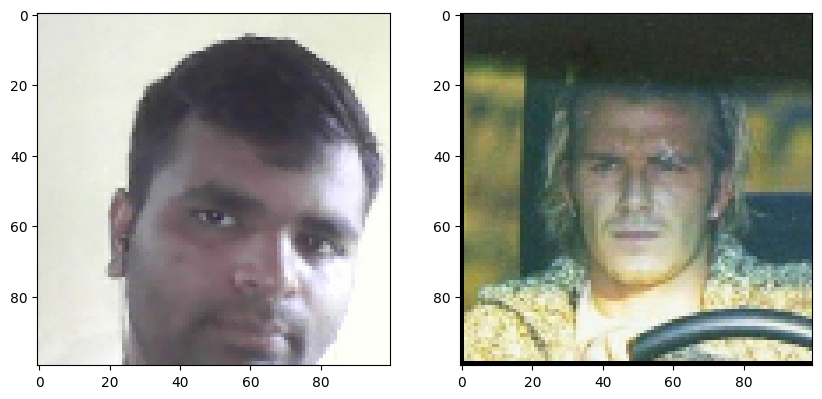

In [26]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [27]:
siamese_model.save('siamesemodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
L1Dist

__main__.L1Dist

In [13]:
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


TypeError: Exception encountered when calling L1Dist.call().

[1mCould not automatically infer the output shape / dtype of 'l1_dist_6' (of type L1Dist). Either the `L1Dist.call()` method is incorrect, or you need to implement the `L1Dist.compute_output_spec() / compute_output_shape()` method. Error encountered:

Failed to convert elements of ['embedding', 2, 0] to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.[0m

Arguments received by L1Dist.call():
  • args=('<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_47>',)
  • kwargs={'validation_embedding': ["'embedding'", '2', '0']}

In [30]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 207ms/step


array([[9.9998724e-01],
       [4.4448875e-06],
       [9.9995852e-01],
       [9.9976248e-01],
       [1.0000000e+00],
       [9.9864632e-01],
       [1.7124773e-07],
       [5.3444030e-08],
       [1.0000000e+00],
       [9.9974400e-01],
       [2.4649753e-06],
       [1.0000000e+00],
       [1.0873239e-07],
       [9.9981648e-01],
       [9.9971992e-01],
       [1.0000000e+00]], dtype=float32)

'application_data/input_image/input_image.jpg'

In [36]:
# for image in os.listdir(os.path.join('application_data', 'verification_images')):
#     validation_img = os.path.join('application_data', 'verification_images', image)
#     print(validation_img)

FileNotFoundError: [Errno 2] No such file or directory: 'application_data/verification_images'

In [3]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []

    for iimage in os.listdir(os.path.join('application_data', 'input_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', iimage))
        validation_img = preprocess(os.path.join('application_data', 'base_image', "base_image.jpg"))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    return results, verified

In [35]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # qRun verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img

# def preprocess(img_path):
#     img = load_img(img_path, target_size=(100, 100))  # Adjust size as needed
#     img = img_to_array(img)
#     img = img / 255.0  # Normalize image
#     return img

def verify(model, verification_threshold):
    # Base image path and preprocessing
    base_image_path = os.path.join('application_data', 'base_image', "base_image.jpg")
    base_image = preprocess(base_image_path)

    # Store results
    results = []

    # Loop through each input image
    for iimage in os.listdir(os.path.join('application_data', 'input_images')):
        input_img_path = os.path.join('application_data', 'input_images', iimage)
        input_img = preprocess(input_img_path)

        # Predict similarity
        result = model.predict([np.expand_dims(base_image, axis=0), np.expand_dims(input_img, axis=0)])
        similarity = result[0][0]
        verified = similarity > verification_threshold

        # Log the result
        print(f'Input Image: {iimage}, Similarity: {similarity:.2f}, Verified: {"Match" if verified else "No Match"}')
        #results.append((iimage, similarity, verified))
        fig, axs = plt.subplots(1, 2, figsize=(10, 1))
        base_img = load_img(base_image_path)
        axs[1, 0].imshow(base_img)
        axs[1, 0].axis('off')
        axs[1, 0].set_title('Base Image')

        # Display input image
        input_img = load_img(input_img_path)
        axs[1, 1].imshow(input_img)
        axs[1, 1].axis('off')
        axs[1, 1].set_title(f'Input Image: {img_name}\nVerified: {"Match" if verified else "No Match"}\nSimilarity: {similarity:.2f}')


    # Display images with verification status
    plt.show()
    return results

# Example usage


In [ ]:
result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

In [5]:
results = verify(siamese_model, verification_threshold=0.5)


NameError: name 'siamese_model' is not defined